In [10]:
import logging
from heart_library.catalogue.workflows import CreateObjectDetectionPatch
from heart_library.metrics import HeartMAPMetric


import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector, JaticPyTorchObjectDetectionOutput
from heart_library.attacks.attack import JaticAttack
from heart_library.estimators.object_detection.pytorch import JaticPyTorchObjectDetector
import requests

from art.attacks.evasion import AdversarialPatchPyTorch
from datasets import load_dataset
import torch

import cv2
import matplotlib.pyplot as plt
import math

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

coco_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


def create_mask(image: np.ndarray, bboxes: list):
    """
    Create a mask using bounding box coordinates.

    Args:
        image (np.ndarray): Input image as a NumPy array (HWC format).
        bboxes (list of tuples): List of bounding boxes in [x_min, y_min, x_max, y_max] format.

    Returns:
        np.ndarray: Mask with 1s for bounding box regions and 0s elsewhere.
    """
    # Get image dimensions
    _, height, width = np.asarray(image).shape

    # Initialize mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Iterate through bounding boxes and set mask values
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        mask[math.floor(y_min):math.ceil(y_max), math.floor(x_min):math.ceil(x_max)] = True  # Set region to 1

    return mask 


def adjust_bboxes_resize(bboxes, original_width, original_height, target_width=640, target_height=640):
    """
    Adjust bounding boxes for images resized to a fixed width and height (640x640).

    Args:
        bboxes (list of lists): Bounding boxes in [x, y, width, height] format.
        original_width (int): Original width of the image.
        original_height (int): Original height of the image.
        target_width (int): Target width of the resized image.
        target_height (int): Target height of the resized image.

    Returns:
        list of lists: Adjusted bounding boxes in [x_min, y_min, x_max, y_max] format.
    """
    # Compute scaling factors
    scale_x = target_width / original_width
    scale_y = target_height / original_height

    adjusted_bboxes = []
    for bbox in bboxes:
        x, y, width, height = bbox
        x_min = x * scale_x
        y_min = y * scale_y
        x_max = (x + width) * scale_x
        y_max = (y + height) * scale_y
        adjusted_bboxes.append([x_min, y_min, x_max, y_max])

    return adjusted_bboxes


def extract_predictions(predictions_, conf_thresh, labels=coco_labels):
    # Get the predicted class
    predictions_class = [labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    
    text_size = 1
    text_th = 2
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    
    
# load the COCO labels for Faster RCNN
coco_label_url = "https://gist.githubusercontent.com/tersekmatija/9d00c4683d52d94cf348acae29e8db1a/raw/8d1b042e7dd6061c760422f51e8e8488c6ad68c7/coco-labels-91.txt"
response = requests.get(coco_label_url)
data = response.text
coco_labels = ['background']  + data.splitlines()

model

In [11]:
detector = JaticPyTorchObjectDetector(model_type="fasterrcnn_resnet50_fpn", input_shape=(3, 200, 200),
                                      clip_values=(0,1),
                                      attack_losses=("loss_classifier",
                                                    "loss_box_reg",
                                                    "loss_objectness",
                                                    "loss_rpn_box_reg",))

dataset

In [12]:
from typing import Tuple, Dict, Any
import random

dataset = load_dataset("rafaelpadilla/coco2017", split="train[20:30]")

preprocess = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

data = dataset.map(lambda x: {"image": preprocess(x["image"]),
                              "resized_bbox": adjust_bboxes_resize(x["objects"]["bbox"],
                                                                            np.asarray(x["image"]).shape[1],
                                                                            np.asarray(x["image"]).shape[0],
                                                                            200,
                                                                            200)})
sample_data = torch.utils.data.Subset(data, list(range(5)))


class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, data, target_label = -1):
        self._data = data
        self._target_label = target_label
        
    def __len__(self)->int:
        return len(self._data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self._data[ind]["image"]
        detection = {}
        detection["boxes"] = np.asarray(self._data[ind]['resized_bbox'])[:1]
        # detection["labels"] = np.asarray(self._data[ind]['objects']['label'])[:1]
        if self._target_label != -1:
            detection["labels"] =[self._target_label]*len(detection['boxes'])
            detection["scores"] = np.asarray([[round(random.uniform(0.95, 1), 5)] for _ in range(len(detection['labels']))])
        else:
            detection["labels"] = np.asarray(self._data[ind]['objects']['label'])[:1]
            detection["scores"] = np.asarray([[round(random.uniform(0.5, 1), 5)] for _ in range(len(detection['labels']))])[:1]
        return (image, JaticPyTorchObjectDetectionOutput(detection), {"mask": create_mask(image, detection["boxes"])})
    
coco_data = ImageDataset(sample_data, target_label=coco_labels.index("train"))
coco_data = torch.utils.data.Subset(coco_data, list(range(len(coco_data))))

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

attack

In [ ]:
rotation_max=0.0
scale_min=0.3
scale_max=0.3
distortion_scale_max=0.0
learning_rate=0.01
max_iter=10
batch_size=1
patch_shape=(3, 100, 100)
patch_location=(50, 50) # to apply _random_overlay i.e. random translation of the patch
patch_type="circle"
optimizer="pgd"

attack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True))

In [ ]:
adv_images, _, metadata = attack(coco_data)
patch = metadata[0]['patch']
# get prediction
adv_detections = detector(adv_images)
preds_orig = extract_predictions(adv_detections[0], 0.5)
label = preds_orig[0]
score = preds_orig[2]
print(f"detected class: {label}\nconfidence: {score}\n-----")

Adversarial Patch PyTorch:   0%|          | 0/10 [00:00<?, ?it/s]

detected class: ['train']
confidence: [0.92180115]
-----


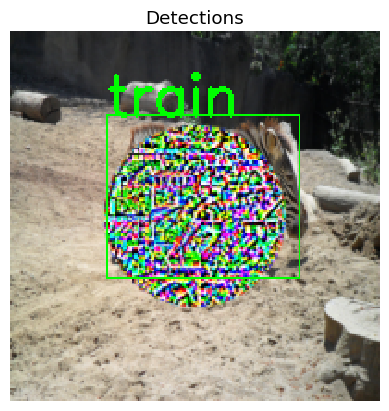

In [ ]:
%matplotlib inline

img = np.asarray(adv_images[0]).transpose(1,2,0)
plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

ToDo:
    - finish create patch
        - use notebook fixed model, dataset values according to MAITE protocols
        - 


In [ ]:
map_args = {"box_format": "xyxy",
            "iou_type": "bbox",
            "iou_thresholds": [0.5],
            "rec_thresholds": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "max_detection_thresholds": [1, 10, 100],
            "class_metrics": False,
            "extended_summary": False,
            "average": "macro"}
metric = HeartMAPMetric(**map_args)

gt_data = ImageDataset(sample_data)
gt_data = torch.utils.data.Subset(gt_data, list(range(len(gt_data))))
gt = [item[1] for item in gt_data]

detections = detector(gt_data)
metric.reset()
metric.update(detections, gt)
metric.compute()

{'map': tensor(0.66667),
 'map_50': tensor(0.66667),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.66667),
 'map_large': tensor(1.),
 'mar_1': tensor(0.60000),
 'mar_10': tensor(0.80000),
 'mar_100': tensor(0.80000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.66667),
 'mar_large': tensor(1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  7,  8,  9, 17, 19, 20, 21, 22, 24, 25, 27, 31, 33, 41, 47, 50, 51, 52, 64, 70, 78, 81, 82, 84, 86], dtype=torch.int32)}

In [ ]:
metric.update(adv_detections, gt)
metric.compute()

{'map': tensor(0.47433),
 'map_50': tensor(0.47433),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.39731),
 'map_large': tensor(1.),
 'mar_1': tensor(0.40000),
 'mar_10': tensor(0.70000),
 'mar_100': tensor(0.70000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.50000),
 'mar_large': tensor(1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 15, 17, 19, 20, 21, 22, 24, 25, 27, 31, 33, 41, 47, 50, 51, 52, 59, 61, 62, 64, 70, 78, 79, 81, 82, 84, 86, 87], dtype=torch.int32)}

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/10 [00:00<?, ?it/s]

benign metrics {'map': tensor(0.75000), 'map_50': tensor(0.75000), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(1.), 'map_large': tensor(1.), 'mar_1': tensor(0.50000), 'mar_10': tensor(1.), 'mar_100': tensor(1.), 'mar_small': tensor(-1.), 'mar_medium': tensor(1.), 'mar_large': tensor(1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1, 17, 19, 20, 21, 22, 24, 25, 31, 47, 50, 51, 52, 64, 86], dtype=torch.int32)}
robust metrics {'map': tensor(0.12500), 'map_50': tensor(0.12500), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.50000), 'mar_100': tensor(0.50000), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  7, 15, 20, 21, 24, 25, 36, 40, 52], dtype=torch.int32)}
adv_metrics {'map': tensor(0.20000), 'map_50': tensor(0.2

False

In [21]:
rotation_max=0.0
scale_min=0.3
scale_max=0.3
distortion_scale_max=0.0
learning_rate=0.01
max_iter=1
batch_size=1
patch_shape=(3, 100, 100)
patch_location=(50, 50) # to apply _random_overlay i.e. random translation of the patch
patch_type="circle"
optimizer="pgd"

attack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True))

In [26]:
attack.reset_patch(workflow._patch)

In [27]:
adv_images, _, metadata = attack(coco_data)
patch = metadata[0]['patch']

Adversarial Patch PyTorch:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
from heart_library.catalogue.workflows import CreateObjectDetectionPatch

workflow = CreateObjectDetectionPatch()
workflow.run()

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/10 [00:00<?, ?it/s]

metadadta benign perf 0.75


False

In [4]:
workflow._benign_metrics['map_50'].item()

0.75

In [40]:
{"boxes": np.asarray([item[1].boxes[0] for item in coco_data]),
 "scores": np.asarray([item[1].scores[0] for item in coco_data]).ravel(),
 "labels": np.asarray([item[1].labels[0] for item in coco_data]).ravel()}

{'boxes': array([[     55.191,      48.983,      161.17,       129.8],
        [     65.512,     0.89882,      153.66,      195.07],
        [     14.983,      70.113,      91.087,      197.75],
        [     79.963,           0,      151.08,      31.892],
        [     105.26,      93.113,      181.53,      142.33]]),
 'scores': array([    0.96112,      0.9768,     0.99519,     0.98237,     0.99779]),
 'labels': array([7, 7, 7, 7, 7])}

In [11]:
import mlflow

all_runs = mlflow.search_runs(search_all_experiments=True, 
                              experiment_names=[workflow.WORKFLOW_NAME], 
                              filter_string="metrics.map_50_benign>0.2")
all_runs

,run_id,experiment_id,status,artifact_uri,start_time,...,tags.mlflow.source.name,tags.mlflow.workflow_task,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
0,661bd83203e942ae92acb09523ade255,810029338750900693,FINISHED,/Users/kieranfraser/git/work/cdao/gitlab/heart...,2025-01-15 02:09:42.359000+00:00,...,/Users/kieranfraser/git/work/cdao/gitlab/heart...,detection,kieranfraser,LOCAL,tasteful-snipe-915
1,217a3acf313c43bc930563f188a1d381,810029338750900693,FINISHED,/Users/kieranfraser/git/work/cdao/gitlab/heart...,2025-01-15 02:03:55.253000+00:00,...,/Users/kieranfraser/git/work/cdao/gitlab/heart...,detection,kieranfraser,LOCAL,spiffy-fly-712


In [ ]:
all_runs['params.model_name']

0    fasterrcnn_resnet50_fpn
1    fasterrcnn_resnet50_fpn
Name: params.model_name, dtype: object